# Numerical Orbit Propagation - Part 1

This tutorial has two basic steps:

1.  Propagating an orbit around the Earth
2.  Plotting the results

The [second installment](numerical_prop_2.ipynb) expands this concept to propagation around a preset celestial body
(Moon) and then a user defined planet (Saturn).


## Brief Introduction to Propagation

The tutorial [Propagation with a TLE](satmad_first_steps.ipynb) introduced many basic concepts with initialising and
propagating an orbit. However, initialising and propagating a numerical orbit is a somewhat different process.

The first difference is that the initial conditions are not defined with a Two-Line Element (or orbital elements
in general) but with cartesian position and velocity at a given time and a coordinate frame.

The second difference is the definition of a central body, and a force model in a numerical propagation. The
SGP4 propagator used with the TLEs implicitly define the central body as the Earth and uses a certain, simplified
force model.

The third and the biggest difference is actually happening under the hood. The SGP4 propagator can take the TLE input
and compute where the satellite is going to be after a certain time using analytical methods and, if the intermediate
points are not required, the runtime is irrespective of the target time - simply, to ask "where will the satellite be
in 10 minutes" or "in 10 years" take the same amount of computational time. On the other hand, a numerical
propagator has to "walk" the time between the initial time and target time with fixed or varying timesteps, using a
numerical differential equation solver. This means that propagating the orbit for 10 minutes and 10 years will take a
significantly different amount of time.

More information regarding numerical propagation schemes can be found
[here](../propagation/numerical_propagation.rst) and
[here](https://satmad-applications.readthedocs.io/en/latest/analyses/propagation/num_prop_performance_1.html).

Be it analytical or numerical, there are three steps to propagation.

1.  Preparing the initial coordinates
2.  Configuring and initialising the propagator
3.  Running the propagation itself

## Propagating an Orbit around the Earth

Let's start with the initial conditions for the Earth-based propagation. We need time, position and velocity in a
coordinate frame of the user's choice. The propagation itself takes place in the inertial frame around the central body
(e.g. GCRS for Earth), but the coordinate transformation is handled automatically within the propagator.

In [1]:
from astropy import units as u
from astropy.coordinates import CartesianDifferential, CartesianRepresentation
from astropy.time import Time
from matplotlib.ticker import AutoLocator
from satmad.coordinates.frames import init_rvt

from satmad.propagation.numerical_propagators import NumericalPropagator
from satmad.utils.timeinterval import TimeInterval

time = Time("2018-07-17T04:57:57.828", scale="utc")

r_earth_itrs = CartesianRepresentation([-6919.50403465,1337.95467332,  0.13856761], unit=u.km)
v_earth_itrs = CartesianDifferential([-0.30139302, -1.54850934, 7.45288544], unit=u.km / u.s)

rv_earth_itrs = init_rvt("itrs", time, r_earth_itrs, v_earth_itrs)

print(rv_earth_itrs)

<SkyCoord (ITRS: obstime=2018-07-17T04:57:57.828): (x, y, z) in km
    (-6919.50403465, 1337.95467332, 0.13856761)
 (v_x, v_y, v_z) in km / s
    (-0.30139302, -1.54850934, 7.45288544)>


This completes the generation of the initial state vector. This state vector usually comes from some other source
(for example, from online orbital data sources or downloaded from the GNSS receiver of the satellite), but for this
example we have specified it explicitly.

The next step is to initialise the numerical propagator. The details of how the parameters should be set can be found
[here](../propagation/numerical_propagation.rst) and
[here](https://satmad-applications.readthedocs.io/en/latest/analyses/propagation/num_prop_performance_1.html).

While all parameters are optional, and the propagator will initialise a reasonably good Earth-bound propagator, two
points are explicitly set in the following example. The first one is the `output_stepsize`, as this will determine the
temporal spacing of the output points. The second ones are the tolerance parameters `atol` and `rtol`. As a general
rule they should be set to roughly similar orders of magnitude, and small values such as `1E-10` to `1E-12` for good
accuracy for a few days. For several weeks, `1E-12` to `1E-14` would probably be required. It should be noted that, the
lower the tolerances, the slower the propagation.

In [2]:
# propagation config params
output_stepsize = 60 * u.s

# init propagator
prop_earth = NumericalPropagator(
    output_stepsize,
    rtol=1e-12,
    atol=1e-14,
)

Once the propagator is configured, next step is to determine the required start and end time of the propagation. The
`gen_trajectory` method runs the propagation and yields a [`Trajectory` object](../coordinates/trajectory.rst)
that holds all intermediate points for the propagation duration.
This object can also provide the coordinates at an arbitrary time within the propagation time interval through
interpolators.

In [3]:
#propagation run params
prop_duration = 3 * u.day
prop_start = rv_earth_itrs.obstime + 0.5 * u.day

# run propagation
trajectory_earth = prop_earth.gen_trajectory(rv_earth_itrs, TimeInterval(prop_start, prop_duration))

print(trajectory_earth)

print(f"Coords at time {prop_start + 0.33453 * u.day}:\n{trajectory_earth(prop_start + 0.33453 * u.day)}")

Trajectory from 2018-07-17T16:57:57.828 to 2018-07-20T16:57:57.828 in frame gcrs. (Interpolators initialised: False)
Coords at time 2018-07-18T00:59:41.220:
<SkyCoord (GCRS: obstime=2018-07-18T00:59:41.220, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (x, y, z) in km
    (7861.85979469, -505.21493495, 947.38487859)
 (v_x, v_y, v_z) in km / s
    (0.96037102, 1.81301659, -6.56227431)>


This concludes the numerical propagation around the Earth. Now on to plotting the orbit in 2D and 3D.

The first plot is the altitude of the satellite. While this a standard plot, there is a small trick. The use of
`quantity_support()` and `time_support()` enables units support to the plots, courtesy of Astropy.
Time format of `isot` is specified for the plot.

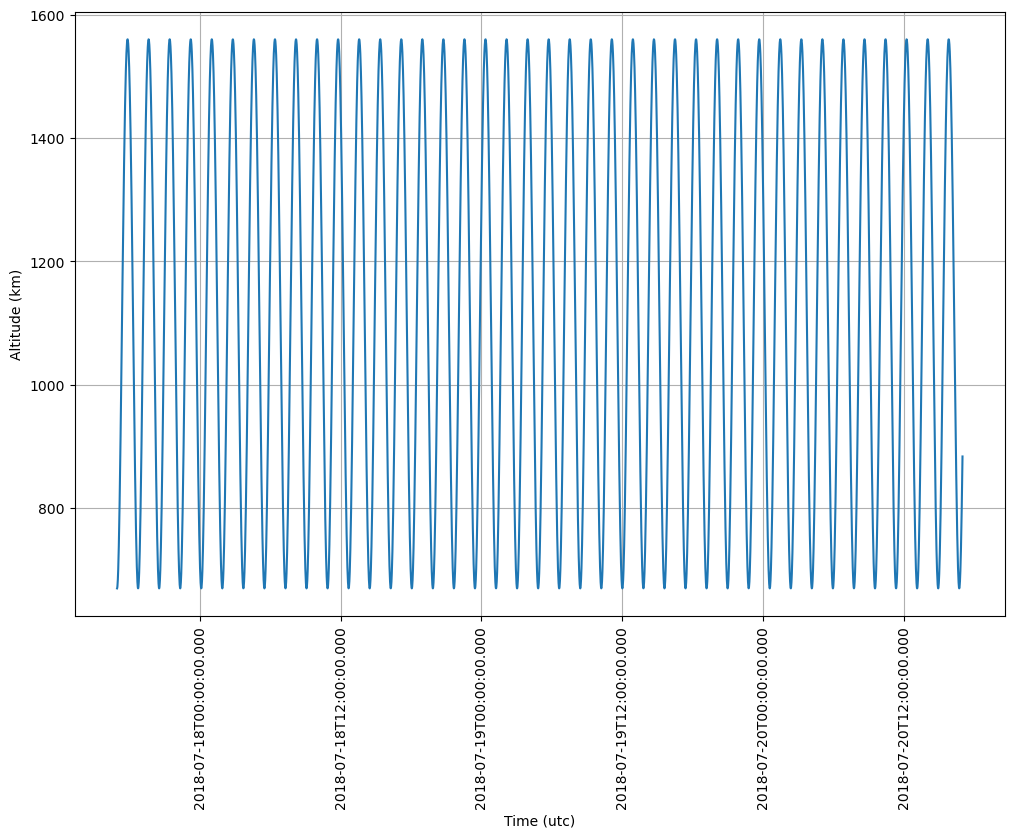

In [4]:
from astropy.visualization import time_support, quantity_support
from matplotlib import pyplot as plt

from satmad.core.celestial_bodies import EARTH

quantity_support()
time_support(format='isot')

time_list = trajectory_earth.coord_list.obstime
alt_list = trajectory_earth.coord_list.cartesian.norm() - EARTH.ellipsoid.re

fig1, ax1 = plt.subplots(figsize=(12,8), dpi=100)

# Format axes - Change major ticks and turn grid on
ax1.xaxis.set_major_locator(AutoLocator())
ax1.yaxis.set_major_locator(AutoLocator())

ax1.grid(True)

# Set axis labels
ax1.set_ylabel("Altitude (km)")

# Rotate x axis labels
ax1.tick_params(axis="x", labelrotation=90)

# plot the data and show the plot
ax1.plot(time_list, alt_list)

plt.show()

The plot essentially tells us the period of the satellite, and the max/min altitudes - as these two are rather close, we
can say that the satellite is on a near-circular orbit.

Now we can try the 3D plot.

In [5]:
%matplotlib notebook

xyz_list = trajectory_earth.coord_list.cartesian.xyz

fig2 = plt.figure(figsize=(12,8), dpi=100)
ax2 = plt.axes(projection="3d")

# Set axis labels
ax2.set_xlabel("x (km)")
ax2.set_ylabel("y (km)")
ax2.set_zlabel("z (km)")

# plot the data and show the plot
ax2.plot3D(xyz_list[0], xyz_list[1], xyz_list[2])

<IPython.core.display.Javascript object>